## _*Initializing next computation from prior result*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using VQE and RYRZ. It is compared to the same energies as computed by the ExactEigensolver and we also compare using the previous computed optimal solution as the starting initial point for the next distance.

This notebook has been written to use the PYQUANTE chemistry driver. See the PYQUANTE chemistry driver readme if you need to install the external PyQuante2 library that this driver requires.

In [1]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.drivers import PyQuanteDriver, BasisType
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = [{'name': 'VQE'},
              {'name': 'VQE'},
              {'name': 'ExactEigensolver'}]
titles= ['VQE Random Seed', 'VQE + Initial Point', 'ExactEigensolver']

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)
eval_counts = np.zeros([len(algorithms), steps+1], dtype=np.intp)

aqua_globals.random_seed = 50

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    for j in range(len(algorithms)):
        driver = PyQuanteDriver(molecule.format(d/2), basis=BasisType.BSTO3G)
        qmolecule = driver.run()
        operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY, two_qubit_reduction=True)
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j]['name'] == 'ExactEigensolver':
            result = ExactEigensolver(qubit_op).run()
        else:
            optimizer = COBYLA(maxiter=10000)
            var_form = RYRZ(qubit_op.num_qubits, depth=5, entanglement='linear')
            algo = VQE(qubit_op, var_form, optimizer)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                seed_simulator=aqua_globals.random_seed,
                                seed_transpiler=aqua_globals.random_seed))
        
        lines, result = operator.process_algorithm_result(result)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
        if algorithms[j]['name'] == 'VQE':
            eval_counts[j][i] = result['algorithm_retvals']['eval_count']
            if j == 1:
                algorithms[j]['initial_point'] = result['algorithm_retvals']['opt_params'].tolist()
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)


Couldn't find cython int routine
Couldn't find cython int routine
Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.05515974 -1.07591361 -1.09262988 -1.10591802 -1.11628599 -1.1241609
  -1.12990476 -1.13382621 -1.13618944 -1.13722136 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467176 -1.12056028 -1.11609625
  -1.11133943 -1.10634212 -1.10115034]
 [-1.05515974 -1.07591361 -1.09262988 -1.10591802 -1.11628599 -1.1241609
  -1.12990476 -1.13382621 -1.13618944 -1.13722136 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836189 -1.12467175 -1.12056029 -1.11609625
  -1.11133943 -1.10634212 -1.10115034]
 [-1.05515975 -1.07591362 -1.09262988 -1.10591802 -1.11628599 -1.1241609
  -1.12990477 -1.13382621 -1.13618945 -1.13722136 -1.13711707 -1.13604437
  -1.13414767 -1.13155121 -1.12836189 -1.12467176 -1.12056029 -1.11609625
  -1.11133

The plot of ground energies from VQE, whether starting from a random initial point or the optimal solution from the prior point are indistinguisable here.

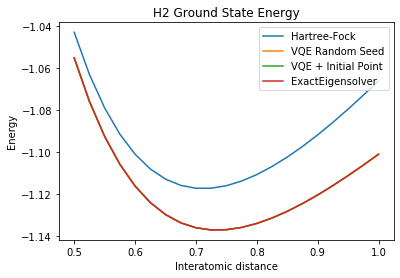

In [2]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=titles[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right');

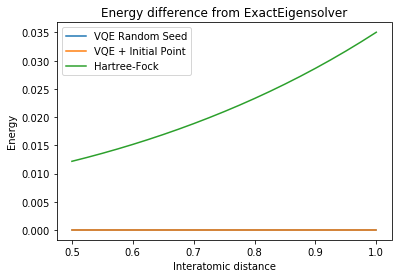

In [3]:
for i in range(2):
    pylab.plot(distances, np.subtract(energies[i], energies[2]), label=titles[i])
pylab.plot(distances, np.subtract(hf_energies, energies[2]), label='Hartree-Fock')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper left');

Lets plot the difference of the VQE ground state energies from the ExactEigensolver. They are both in the same ballpark and both very small.

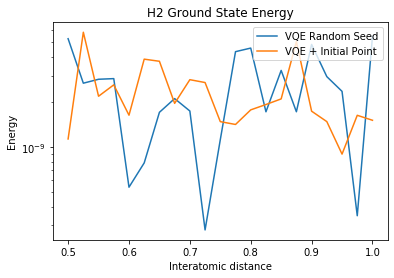

In [4]:
for i in range(len(algorithms)-1):
    pylab.plot(distances, np.subtract(energies[i], energies[2]), label=titles[i])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.yscale('log')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right');

Finally lets plot the number of evaluations taken at each point. Both start out at the same number since we start them the same. But we can see, as we step along small distances, that the prior solution is a better guess as the starting point for the next step leading to fewer evaluations.

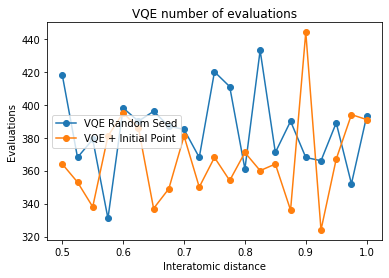

In [5]:
for i in range(2):
    pylab.plot(distances, eval_counts[i], '-o', label=titles[i])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Evaluations')
pylab.title('VQE number of evaluations')
pylab.legend(loc='center left');

In [6]:
for i in range(2):
    print("Total evaluations for '{}' = {}".format(titles[i], np.sum(eval_counts[i])))

percent = np.sum(eval_counts[1])*100/np.sum(eval_counts[0])
print("\nTotal evaluations for '{}' are {:.2f}% of '{}'".format(titles[1], percent, titles[0]))

Total evaluations for 'VQE Random Seed' = 8074
Total evaluations for 'VQE + Initial Point' = 7707

Total evaluations for 'VQE + Initial Point' are 95.45% of 'VQE Random Seed'
